In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from collections import Counter, defaultdict
from itertools import product, combinations
import math
import cv2
from sklearn.model_selection import train_test_split

random.seed(42)

%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

/home/anurag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
IMAGE_SIZE = (80, 80)

def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
       
    return resized_image

In [4]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

## The below cell need to be replaced with the location of the new data

In [8]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"): 
                    

                    img_file_loc = os.path.join(piece_type_folder, f)
                    # print(img_file_loc)
                    grayscale_image = process_image(img_file_loc)
                    actual_image = grayscale_image
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label, "image": actual_image})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    images = [x["image"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y), images

In [9]:
X_train, y_train, _ = get_features_labels("/home/anurag/AR/data/23March/train")
X_test, y_test, test_images = get_features_labels("/home/anurag/AR/data/23March/test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5838, 80, 80, 3)
(5838,)
(291, 80, 80, 3)
(291,)


In [10]:
# batch size
batch_size = 64


required_input_shape = (*IMAGE_SIZE, 3)

In [13]:
import keras
from keras.layers import Input, Dense, Flatten,MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import SGD,Adam


import numpy.random as rng
from keras.applications.xception import Xception

def load_6_class_classifier():
    

    base_model = Xception(include_top=False, weights='imagenet', input_shape=required_input_shape)
    # add a global spatial average pooling layer

    x = base_model.output

    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a softmax layer
    predictions = Dense(6, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # load the model weights
    model.load_weights("/home/anurag/AR/Extending-Board-Games-using-deep-learning/API/models/6_class_xception.hdf5")
                        
    adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [14]:
trained_model = load_6_class_classifier()

In [15]:
# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 3.9201845319820023
Test accuracy: 0.13402061855670103


In [16]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
import matplotlib
matplotlib.rcParams['figure.figsize'] = [100, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
            else:
                axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

## Check predictions using the best trained model

In [17]:
X_test, y_test, test_images = get_features_labels("/home/anurag/AR/sriraj_v2/test_v2")
y_test

array([2, 3, 5, 3, 4, 2, 1, 5, 2, 1, 1, 1, 1, 0, 2, 1, 4, 3, 4, 0, 3, 2,
       2, 5, 5, 3, 3, 3, 0, 3, 2, 2, 2, 0, 3, 1, 2, 5, 0, 1, 4, 4, 2, 4,
       0, 0, 3, 3, 1, 3, 0, 5, 1, 0, 4, 2, 2, 2, 1, 1, 0, 2, 3, 1, 0, 2,
       2, 4, 1, 3, 3, 0, 4, 5, 3, 3, 4, 3, 5, 1, 3, 4, 4, 5, 3, 2, 5, 3,
       4, 1, 1, 0, 0, 4, 5, 1, 5, 3, 0, 2, 3, 0, 3, 0, 2, 1, 5, 3, 4, 5,
       0, 0, 4, 0, 1, 1, 5, 3, 3, 0, 2, 5, 1, 0, 2, 1, 0, 2, 1, 2, 1, 5,
       5, 1, 5, 0, 1, 4, 4, 1, 3, 1, 4, 2, 2, 1, 2, 0, 3, 3, 2, 0, 1, 0,
       1, 0, 5, 0, 2, 2, 1, 3, 3, 1, 4, 3, 4, 3, 2, 2, 1, 3, 1, 5, 2, 1,
       0, 0, 0, 3, 3, 2, 5, 2, 0, 1, 2, 4, 0, 5, 3, 2, 1, 3, 0, 2, 2, 2,
       4, 1, 5, 3, 1, 1, 0, 2, 3, 2, 5, 3, 2, 0, 0, 1, 1, 3, 2, 2, 5, 2,
       1, 1, 2, 1, 2, 2, 3, 3, 1, 3, 3, 4, 3, 5, 2, 4, 0, 1, 1, 4, 1, 5,
       0, 5, 1, 3, 0, 0, 1, 2, 3, 3, 0, 3, 4, 1, 4, 0, 3, 0, 2, 4, 0, 3,
       3, 2, 2, 2, 1, 1, 3, 2, 2, 5, 1, 3, 0, 1, 2, 3, 1, 3, 4, 0, 1, 2,
       0, 0, 0, 2, 3])

Confusion matrix, without normalization
[[ 3  0  3 34  2  9]
 [13  2  4 32  4  5]
 [19  2  6 24  4  5]
 [ 5  3 12 13 11 16]
 [ 3  1  2  9 10  5]
 [ 0 13  2  7  3  5]]
0.13402061855670103


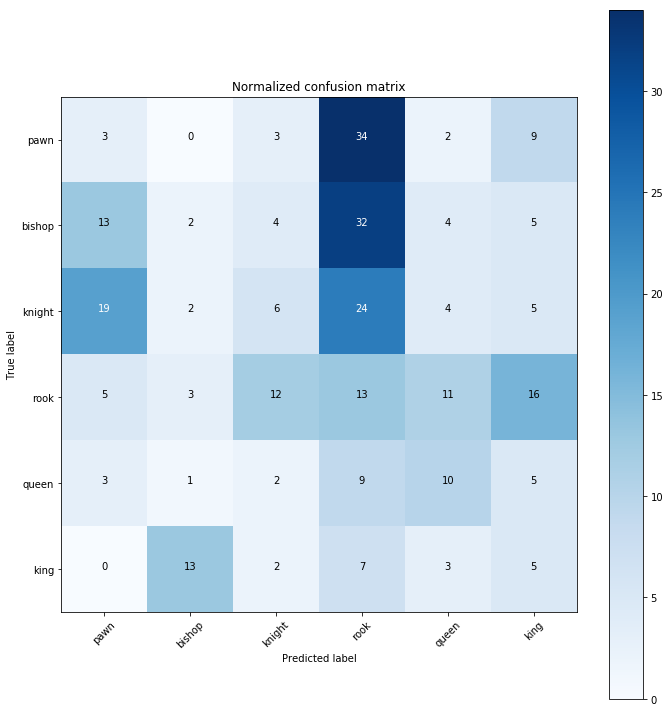

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["pawn", "bishop", "knight", "rook", "queen", "king"]

trained_model = load_6_class_classifier()

# trained_model.load_weights(filepath)

test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

In [20]:
base_location = "/home/anurag/AR/analysis_results/29Mar"
def save_mispredicted_images(images, actual_values, predicted_values, mapping_func = None):
    # print(actual_values)
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)
    if num_rows == 1:
        num_rows = 2

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    # fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            # print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            
            # axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            if mapping_func:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(mapping_func(actual_values[mis_prediction_indices[current_image_idx]]), mapping_func(predicted_values[mis_prediction_indices[current_image_idx]])))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
    
            else:
                image_location = os.path.join(base_location, str(current_image_idx) + "_" + "{0}_as_{1}.jpg".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
                cv2.imwrite(image_location, images[mis_prediction_indices[current_image_idx]])
            #print(current_image_idx)
            current_image_idx += 1    

In [21]:
# test_images = np.squeeze(X_test)
reverse_label_mappings = {type_name_to_label[y]: y for y in type_name_to_label}
print(reverse_label_mappings)
save_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])
# plot_mispredicted_images(test_images, y_test, y_test_pred, lambda x: reverse_label_mappings[x])

{0: 'p', 1: 'b', 2: 'n', 3: 'r', 4: 'q', 5: 'k'}
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  41  42  44  45  46  47  48  49  51  52  53  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  75  76  77  78  79
  80  81  82  83  85  86  88  89  90  91  92  93  95  97  98  99 100 101
 103 105 106 107 108 109 110 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 132 133 134 135 136 138 140 141 143 145
 146 147 149 150 151 152 153 154 155 156 157 159 160 161 163 164 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 184 185 186 188
 189 191 192 195 196 197 198 200 201 202 203 204 205 208 209 211 212 213
 214 216 217 218 219 220 221 222 223 224 225 226 227 228 230 231 232 233
 234 235 236 237 238 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 2